## 1.

*Recogiendo los datos de coronavirus de la página https://ourworldindata.org/coronavirus-source-data* 

A partir de la letra de tu DNI, elige al país que empieza por dicha letra que más fallecidos tenga. Si el país elegido no está entre el top 20 de fallecidos, elige como país España.

En este caso, utilizaremos las columnas:

- Nuevos casos
- Nuevos fallecidos
- Población
- Fallecidos totales
- Casos totales

La fecha debe estar en el índice.

1. Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.

2. Elimina la columna "Población".

3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

4. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y n_repeats = 7 para este ejercicio y solo para la columna "nuevos casos".

In [1]:
import pandas as pd
covid = pd.read_csv("../data/owid-covid-data.csv")


In [3]:
# listo los países top 20
covid[['total_deaths', 'location']].sort_values('total_deaths', ascending=False).nlargest(20, 'total_deaths')

# aparece 'World'


,total_deaths,location
95091,3842291.0,World
95090,3832997.0,World
95089,3822698.0,World
95088,3812116.0,World
95087,3804235.0,World
95086,3795088.0,World
95085,3785332.0,World
95084,3773403.0,World
95083,3757400.0,World
95082,3746949.0,World


In [4]:
# elimino de la columna 'location' la categoría 'world' y las correspondientes a los continentes 'Africa', 'Europe', 'European Union', 'South America', 'Asia', 'Oceanía' así como 'International'

location_R = covid[(covid['location'] == 'World') | (covid['location'] == 'Africa') | (covid['location'] == 'Europe') | (covid['location'] == 'European Union') | (covid['location'] == 'South America') | (covid['location'] == 'North America') | (covid['location'] == 'Asia') | (covid['location'] == 'Oceania') | (covid['location'] == 'International') ].index
# Borro estas filas del dataframe
covid.drop(location_R , inplace=True)
# listo los valores únicos de 'location' para comprobar que ya no aparece 'world'
covid['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Faeroe Isl

In [5]:
# listo los Top 20 países respecto al 'Total_deaths'
covid_1 = covid.groupby('location')['total_deaths'].mean().to_frame().reset_index().sort_values(by='total_deaths', ascending = False).nlargest(20, 'total_deaths')

In [6]:
# la letra de mi DNI es 'H'. No hay ningún país en el Top 20 de total de fallecidos que empiece por 'H' así que trabajaré con España
# Creo una nueva base solo con los datos correspondientes a España

Espana = covid.loc[:, 'location'] == 'Spain'

Spain = covid.loc[Espana]

In [12]:
# Seleccionamos del dataframe: 'Spain' las columnas correspondientes a: Total_cases, new_cases, total_deaths, new_deaths y population
Spain_1 = Spain.iloc[:,[3,4,5,7,8,44]]

In [13]:
# coloco la columan fecha como índice
Spain_2 = Spain_1.set_index("date")

In [14]:
Spain_2.columns

Index(['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'population'], dtype='object')

In [ ]:
# Representación gráfica

In [15]:
# Eliminar la columna 'población'
Poblacion = ['population']

Spain_2.drop(Poblacion, inplace = True, axis=1)


In [22]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR, SVC

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, accuracy_score


In [23]:
# Se crea un diccionario con los modelos que interesa comparar


dictionary_model_reg = {"poly_model": Pipeline([
            ("polynomial_features", PolynomialFeatures(3)),
            ("linear_regression", LinearRegression())]),
                    "linear_model": LinearRegression(),
                    "support_model": SVR(),
                    "random_forest": RandomForestRegressor()
                   }

X = np.array(Spain_2["new_cases"]).reshape(-1,1)
y = Spain_2.new_cases

In [24]:
# Función de entrenamiento de los diferentes modelos que quermos comparar


def train_model_reg(dict_model, X, y):
    dict_scores = {"model":[], "score":[], "score_test":[]}
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state = 42)
    print(X_train.shape, y_train.shape)
    
    for k,v in dict_model.items():         
        v.fit(X_train, y_train)
        y_pred = v.predict(X_train)
        y_test_pred = v.predict(X_test)

        score = r2_score(y_train, y_pred)
        score_test = r2_score(y_test, y_test_pred)
   
        lista_val = [k, score, score_test]
        for i,e in enumerate(["model", "score","score_test"]):
            dict_scores[e].append(lista_val[i])

        X_train_to_show, y_train_to_show = zip(*sorted(zip(X_train, y_train)))
        plt.scatter(X_train_to_show, y_train_to_show, color='lightblue')
        
        X_t_to_show, y_t_to_show = zip(*sorted(zip(X_test, y_test)))
        plt.scatter(X_t_to_show, y_t_to_show, color='red')
                                       
        X_train_to_show, y_pred = zip(*sorted(zip(X_train, y_pred)))
        plt.plot(X_train_to_show, y_pred, color='blue')
        plt.title(f"{k}")
        plt.show()
        
    return pd.DataFrame(dict_scores)

(402, 1) (402,)


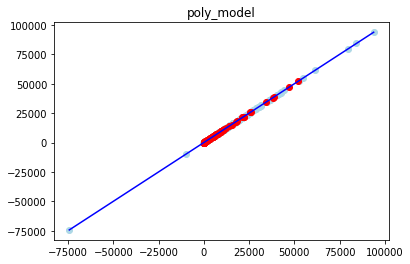

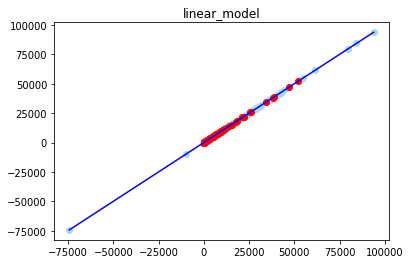

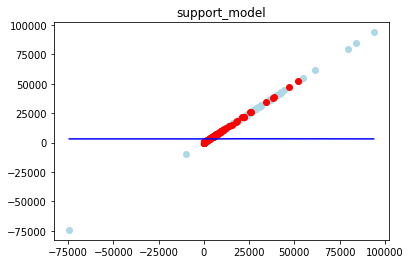

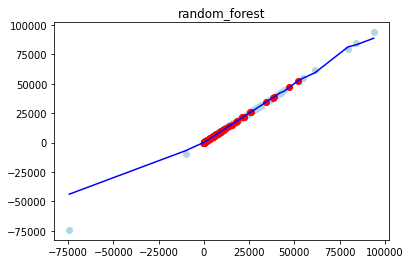

,model,score,score_test
0,poly_model,1.000000,1.000000
1,linear_model,1.000000,1.000000
2,support_model,-0.117444,-0.127163
3,random_forest,0.985696,0.998763


In [26]:
# Representación de los diferentes modelos que hemos entrenado


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots



train_model_reg(dict_model=dictionary_model_reg, X=X, y=y)

In [ ]:
# Almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

# Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y n_repeats = 7 para este ejercicio y solo para la columna "nuevos casos".